Mounted at /content/drive
/content/drive/MyDrive/ApplicationTCC4/datasets/parts/train/conforme
/content/drive/MyDrive/ApplicationTCC4/datasets/parts/train/nao_conforme
Found 1434 images belonging to 2 classes.
Found 358 images belonging to 2 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6339 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 686s 15s/step - loss: 0.6555 - accuracy: 0.6339 - val_loss: 0.5402 - val_accuracy: 0.7654
Epoch 2/25
45/45 [==============================] - 609s 13s/step - loss: 0.5030 - accuracy: 0.7559 - val_loss: 0.5022 - val_accuracy: 0.7458
Epoch 3/25
45/45 [==============================] - 615s 14s/step - loss: 0.4946 - accuracy: 0.7678 - val_loss: 0.3869 - val_accuracy: 0.8547
Epoch 4/25
45/45 [==============================] - 630s 14s/step - loss: 0.4529 - accuracy: 0.7859 - val_loss: 0.3856 - val_accuracy: 0.8380
Epoch 5/25
45/45 [==============================] - 601s 13s/step - loss: 0.4234 - accuracy: 0.8110 - val_loss: 0.3582 - val_accuracy: 0.8687
Epoch 6/25
45/45 [==============================] - 602s 13s/step - loss: 0.3718 - accuracy: 0.8375 - val_loss: 0.3360 - val_accuracy: 0.8687
Epoch 7/25
45/45 [==============================] - 598s 13s/step - loss: 0.3734 - accuracy: 0.8347 - val_loss: 0.3396 - val_accuracy: 0.8799
Epoch 8/25
45/45 

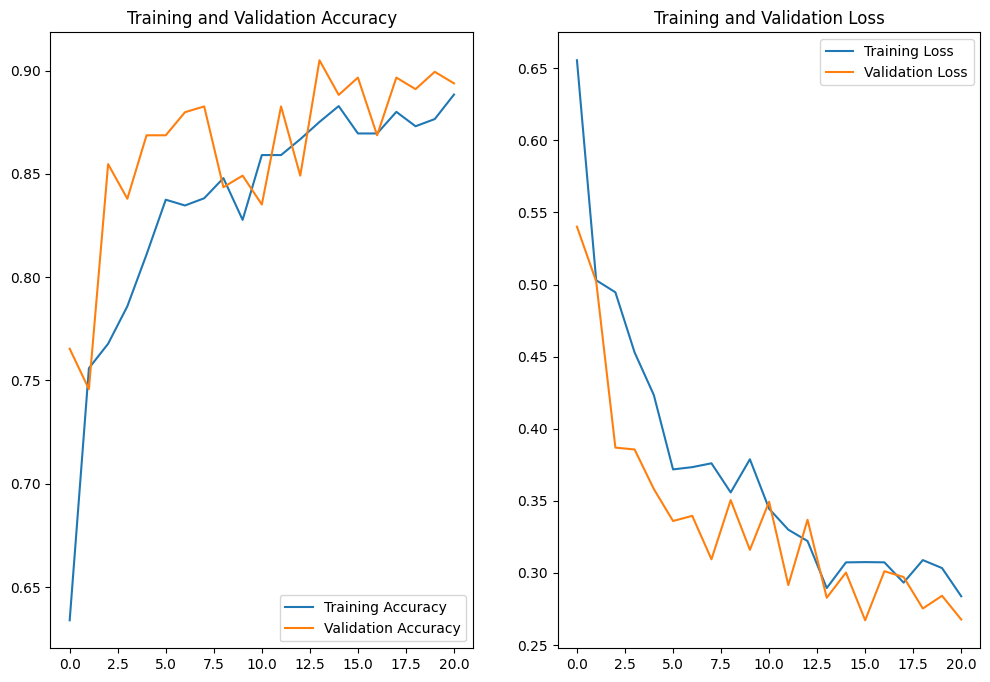

Modelo TFLite salvo como 'model.tflite'


In [ ]:
# Importando bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

# Montando o Google Drive no ambiente do Google Colab
drive.mount('/content/drive')

# Definindo o caminho base para os datasets de treinamento
caminho_base = '/content/drive/MyDrive/ApplicationTCC4/datasets/parts/train'
# Definindo caminhos para as pastas conforme e não conforme
caminho_conforme = os.path.join(caminho_base, 'conforme')
caminho_nao_conforme = os.path.join(caminho_base, 'nao_conforme')

# Imprimindo os caminhos para verificação
print(caminho_conforme) # Tamanho do lote
print(caminho_nao_conforme) # Altura e largura das imagens

# Definindo parâmetros de pré-processamento e carregamento de imagens
batch_size = 32
img_height, img_width = 299, 299

# Utilizando ImageDataGenerator para carregar e pré-processar as imagens com data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Redimensiona os valores dos pixels para o intervalo [0, 1]
    validation_split=0.2, # Reserva 20% dos dados para validação
    rotation_range=20, # Rotaciona as imagens em até 20 graus
    width_shift_range=0.2, # Desloca as imagens horizontalmente em até 20% da largura
    height_shift_range=0.2, # Desloca as imagens verticalmente em até 20% da altura
    shear_range=0.2, # Aplica cisalhamento nas imagens
    zoom_range=0.2, # Aplica zoom nas imagens
    horizontal_flip=True, # Realiza flip horizontal nas imagens
    fill_mode='nearest' # Preenche pixels vazios após transformações com o valor do pixel mais próximo
)

# Carregando as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    caminho_base, # Diretório base
    target_size=(img_height, img_width), # Redimensiona as imagens para 299x299 pixels
    batch_size=batch_size, # Tamanho do lote
    class_mode='binary', # Tipo de classificação binária
    subset='training' # Usa esta parte para treinamento
)

# Carregando as imagens de validação
validation_generator = train_datagen.flow_from_directory(
    caminho_base, # Diretório base
    target_size=(img_height, img_width), # Redimensiona as imagens para 299x299 pixels
    batch_size=batch_size, # Tamanho do lote
    class_mode='binary', # Tipo de classificação binária
    subset='validation' # Usa esta parte para validação
)

# Definindo o modelo base InceptionV3 pré-treinado na base ImageNet
base_model = tf.keras.applications.InceptionV3(input_shape=(img_height, img_width, 3),
                                              include_top=False,  # Exclui a última camada (classificação)
                                              weights='imagenet' ) # Usa pesos pré-treinados do ImageNet
base_model.trainable = False # Congela o modelo base para não treinar novamente

# Construindo o modelo final adicionando novas camadas no topo do modelo base
model = tf.keras.Sequential([
    base_model, # Modelo base
    tf.keras.layers.GlobalAveragePooling2D(), # Camada de pooling global
    tf.keras.layers.Dense(128, activation='relu'), # Camada densa com 128 unidades e ReLU
    tf.keras.layers.Dropout(0.5), # Dropout com taxa de 50% para evitar overfitting
    tf.keras.layers.Dense(1, activation='sigmoid') # Camada final com 1 unidade e ativação sigmoide para classificação binária
])

# Definindo a função de perda, otimizador e métricas
loss = tf.keras.losses.BinaryCrossentropy() # Função de perda para classificação binária
optim = tf.keras.optimizers.Adam(learning_rate=0.001) # Otimizador Adam com taxa de aprendizado de 0.001
metrics = ["accuracy"] # Métrica de acurácia

# Compilando o modelo
model.compile(optimizer=optim, loss=loss, metrics=metrics)

# Definindo callbacks
# EarlyStopping interrompe o treinamento se a perda de validação não melhorar após 5 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ModelCheckpoint salva o melhor modelo baseado na perda de validação
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Definindo o número de épocas
epochs = 25
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(validation_generator.n / batch_size)

# Treinamento do modelo
history = model.fit(
    train_generator, # Dados de treinamento
    steps_per_epoch=steps_per_epoch, # Número de passos por época
    epochs=epochs, # Número de épocas
    validation_data=validation_generator, # Dados de validação
    validation_steps=validation_steps, # Número de passos de validação
    callbacks=[early_stopping, model_checkpoint] # Callbacks definidos
)

# Plotando os resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Extraiu histórico de acurácia e perda

# Definindo intervalo de épocas para plotagem
epochs_range = range(len(acc))

# Criando figura para plotagem
plt.figure(figsize=(12, 8))

# Plotando acurácia de treinamento e validação
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotando perda de treinamento e validação
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Carregando o melhor modelo salvo durante o treinamento
model = tf.keras.models.load_model('best_model.h5')

# Converter o modelo para TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salvar o modelo TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modelo TFLite salvo como 'model.tflite'")
